In [1]:
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding
)

/home/erikt/_dev/txn-classifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-16 12:25:01.389814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 12:25:01.410130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752690301.433846   36900 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752690301.441277   36900 cuda_blas.c

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Print GPU name

True
NVIDIA RTX A2000 Laptop GPU


In [3]:
df_train = pd.read_csv("../data/raw-transactions.csv")
df_train.head()

,id,amount,date,isRecurring,createdAt,updatedAt,merchant_name,cat_label
0,207960217406708418,158.11,2025-04-14,False,2025-04-14T10:38:38.177630+00:00,2025-04-14T22:15:19.137902+00:00,Airbnb 4977,income
1,207960212463720951,-600.00,2025-04-14,False,2025-04-14T10:38:33.465585+00:00,2025-04-14T22:15:21.945296+00:00,Mountain View Ac Sale,taxes
2,207850760872958776,-170.00,2025-04-12,False,2025-04-13T05:38:52.292345+00:00,2025-04-15T01:51:23.081038+00:00,NEAL BRUGMAN PSYD,therapy
3,207850760872958775,-2.99,2025-04-12,True,2025-04-13T05:38:52.292246+00:00,2025-04-15T01:51:22.891655+00:00,Apple,guilt_free
4,207850760872958778,-10.00,2025-04-11,False,2025-04-13T05:38:52.292456+00:00,2025-04-14T22:15:28.784642+00:00,Bandca Subscr,guilt_free


<Axes: ylabel='cat_label'>

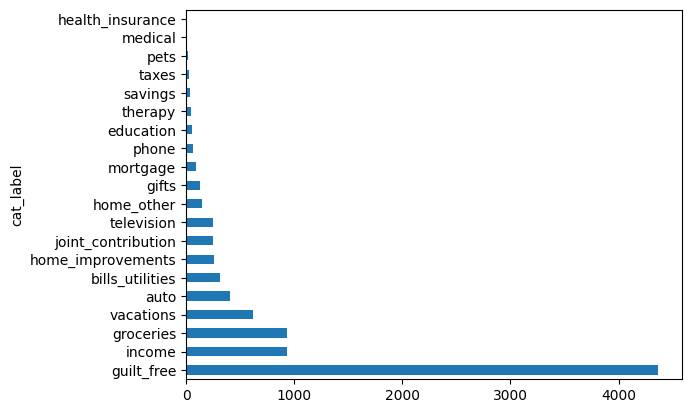

In [4]:
df_train['cat_label'].value_counts().plot(kind='barh')

In [5]:
df_train.head()

,id,amount,date,isRecurring,createdAt,updatedAt,merchant_name,cat_label
0,207960217406708418,158.11,2025-04-14,False,2025-04-14T10:38:38.177630+00:00,2025-04-14T22:15:19.137902+00:00,Airbnb 4977,income
1,207960212463720951,-600.00,2025-04-14,False,2025-04-14T10:38:33.465585+00:00,2025-04-14T22:15:21.945296+00:00,Mountain View Ac Sale,taxes
2,207850760872958776,-170.00,2025-04-12,False,2025-04-13T05:38:52.292345+00:00,2025-04-15T01:51:23.081038+00:00,NEAL BRUGMAN PSYD,therapy
3,207850760872958775,-2.99,2025-04-12,True,2025-04-13T05:38:52.292246+00:00,2025-04-15T01:51:22.891655+00:00,Apple,guilt_free
4,207850760872958778,-10.00,2025-04-11,False,2025-04-13T05:38:52.292456+00:00,2025-04-14T22:15:28.784642+00:00,Bandca Subscr,guilt_free


In [6]:
def clean(text):
    # Separate numbers from letters (e.g., "abc123" → "abc 123")
    text = re.sub(r"([a-zA-Z])(\d)", r"\1 \2", text)
    text = re.sub(r"(\d)([a-zA-Z])", r"\1 \2", text)

    # Lowercase + trim spaces
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

def tokenize(text):
    text = clean(text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text.split()

def get_trans_string(row):
    merchant_text = ' '.join(tokenize(row['merchant_name']))
    return f"Transaction: ${abs(row['amount'])}{" credit" if row['amount'] > 0 else " payment"} at {merchant_text} - Type: {"income" if row['amount'] > 0 else "expense"}"

merchant_sentences = df_train.apply(get_trans_string, axis=1).tolist()
merchant_sentences[:10]


['Transaction: $158.11 credit at airbnb 4977 - Type: income',
 'Transaction: $600.0 payment at mountain view ac sale - Type: expense',
 'Transaction: $170.0 payment at neal brugman psyd - Type: expense',
 'Transaction: $2.99 payment at apple - Type: expense',
 'Transaction: $10.0 payment at bandca subscr - Type: expense',
 'Transaction: $19.95 payment at trade - Type: expense',
 'Transaction: $226.65 payment at xcel energy - Type: expense',
 "Transaction: $11.76 payment at arby's - Type: expense",
 'Transaction: $45.04 payment at sdpy tran ac - Type: expense',
 "Transaction: $12.25 payment at devil's food bakery - Type: expense"]

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "kuro-08/bert-transaction-categorization"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

transaction = merchant_sentences[5]
print(transaction)

inputs = tokenizer(transaction, return_tensors="pt", truncation=True, padding=True)

#  Predict the category
outputs = model(**inputs)
logits = outputs.logits
predicted_category = logits.argmax(-1).item()

print(f"Predicted category: {predicted_category}")

Transaction: $19.95 payment at trade - Type: expense
Predicted category: 22


In [ ]:
# Load your data
df = pd.read_csv("../data/raw-transactions.csv")  # must include merchant_name and cat_label

# Encode labels
le = LabelEncoder()
df["labels"] = le.fit_transform(df["cat_label"])
num_labels = len(le.classes_)

# Train/val split
df_train, df_val = train_test_split(
    df, 
    stratify=df["labels"], 
    test_size=0.2, 
    random_state=42
)

# Load tokenizer and tokenize text
model_name = "kuro-08/bert-transaction-categorization"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["merchant_name"], 
        truncation=True, 
        padding=True, 
        max_length=64
    )

# Convert to Hugging Face Datasets
dataset_train = Dataset.from_pandas(df_train[["merchant_name", "labels"]])
dataset_val = Dataset.from_pandas(df_val[["merchant_name", "labels"]])

# Tokenize
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)

# Set format for PyTorch
dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dataset_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels,
    ignore_mismatched_sizes=True
    )

# Freeze BERT layers (except output)
for name, param in model.bert.named_parameters():
    param.requires_grad = False

# Define metrics
eval_acc = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return eval_acc.compute(predictions=preds, references=p.label_ids)

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-finetuned-transactions",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Map: 100%|██████████| 1795/1795 [00:00<00:00, 27254.77 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kuro-08/bert-transaction-categorization and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([25]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([25, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36900/3165513163.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.622082,0.845682
2,1.013500,0.541883,0.847911
3,0.524000,0.517879,0.864067
4,0.398200,0.511381,0.870195


TrainOutput(global_step=1796, training_loss=0.5974296238480804, metrics={'train_runtime': 2003.0663, 'train_samples_per_second': 14.336, 'train_steps_per_second': 0.897, 'total_flos': 936118484438544.0, 'train_loss': 0.5974296238480804, 'epoch': 4.0})

In [10]:
import joblib

# Save model and tokenizer
model.save_pretrained("bert-finetuned-merchant")
tokenizer.save_pretrained("bert-finetuned-merchant")

# Save label encoder
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [11]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-finetuned-merchant")
tokenizer = AutoTokenizer.from_pretrained("bert-finetuned-merchant")
model.eval()

# Load label encoder
le = joblib.load("label_encoder.pkl")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
def predict_merchant_labels(texts, batch_size=32):
    preds = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            truncation=True,
            padding=True,
            return_tensors="pt",
            max_length=64
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    return preds

texts = df["merchant_name"].astype(str).tolist()
predicted_ids = predict_merchant_labels(texts)

# Map back to original labels
df["bert_finetuned_label"] = le.inverse_transform(predicted_ids)

<Axes: ylabel='cat_label'>

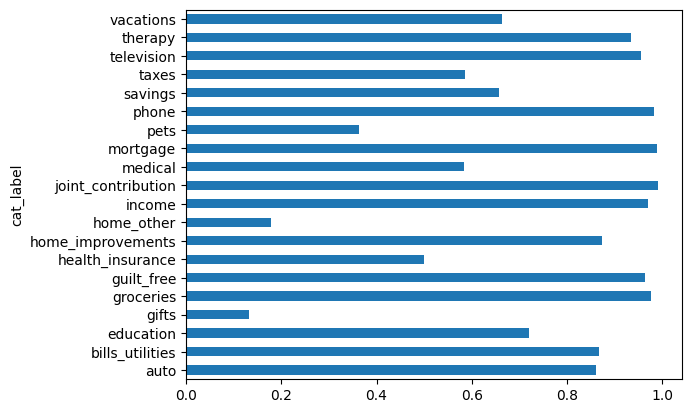

In [13]:
df['accurate_label'] = df['cat_label'] == df['bert_finetuned_label']
df.groupby('cat_label')['accurate_label'].mean().plot(kind='barh')